In [1]:
import torch
print(torch.__version__)  # Kiểm tra phiên bản PyTorch
print(torch.cuda.is_available())  # Kiểm tra xem PyTorch có nhận GPU không
print(torch.version.cuda)  # Kiểm tra phiên bản CUDA mà PyTorch đang sử dụng
print(torch.cuda.get_device_name(0))  # Kiểm tra tên GPU


2.5.1+cu121
True
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\tranh\AppData\Local\Temp\ipykernel_32516\1453888223.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weigh

Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F1-score: 0.9963


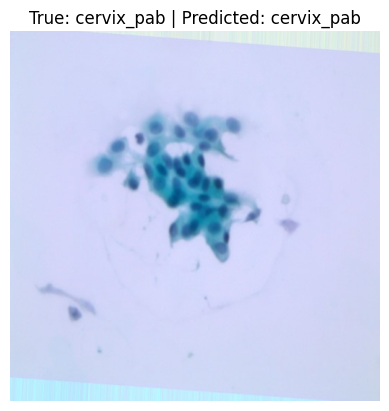

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

# Load dataset paths
dataset_path = './Multi Cancer/Cervical Cancer'
cervix_categories = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

filepaths, labels = [], []
for label, category in enumerate(cervix_categories):
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        filepaths.append(os.path.join(category_path, file))
        labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Split dataset again
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CervicalCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        label = self.df.iloc[idx]['label']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create test DataLoader
test_loader = DataLoader(CervicalCancerDataset(test_df, transform), batch_size=32, shuffle=False)

# Define Model class
class CervicalCancerModel(nn.Module):
    def __init__(self):
        super(CervicalCancerModel, self).__init__()
        self.base_model = models.resnet101(pretrained=False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, len(cervix_categories))
        )
    
    def forward(self, x):
        return self.base_model(x)

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CervicalCancerModel().to(device)
model.load_state_dict(torch.load("cervical_cancer_model.pth", map_location=device))
model.eval()

# Evaluate Model
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Predict a random test image
random_idx = random.randint(0, len(test_df) - 1)
img_path = test_df.iloc[random_idx]['filepath']
true_label = test_df.iloc[random_idx]['label']

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)
input_image = transform(pil_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_image)
    _, predicted_label = torch.max(output, 1)

# Display image and predictions
plt.imshow(pil_image)
plt.title(f"True: {cervix_categories[true_label]} | Predicted: {cervix_categories[predicted_label.item()]}")
plt.axis('off')
plt.show()

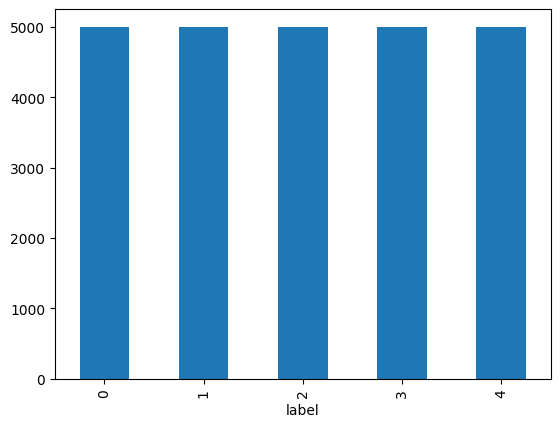

In [3]:
df['label'].value_counts().plot(kind='bar')
plt.show()


In [4]:
train_files = set(train_df['filepath'])
test_files = set(test_df['filepath'])

overlap = train_files.intersection(test_files)
print(f"Số ảnh trùng lặp giữa train và test: {len(overlap)}")


Số ảnh trùng lặp giữa train và test: 0


In [5]:
# Compute metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

for i, category in enumerate(cervix_categories):
    print(f"Class: {category}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}\n")


Class: cervix_dyk
  Precision: 0.9947
  Recall: 0.9933
  F1-score: 0.9940

Class: cervix_koc
  Precision: 0.9934
  Recall: 0.9960
  F1-score: 0.9947

Class: cervix_mep
  Precision: 0.9973
  Recall: 0.9920
  F1-score: 0.9947

Class: cervix_pab
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: cervix_sfi
  Precision: 0.9960
  Recall: 1.0000
  F1-score: 0.9980



In [6]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget




In [7]:
# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)



In [8]:
# Load dataset paths
dataset_path = './Multi Cancer/Cervical Cancer'
cervix_categories = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

filepaths, labels = [], []
for label, category in enumerate(cervix_categories):
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        filepaths.append(os.path.join(category_path, file))
        labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Split dataset again
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)



In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CervicalCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        label = self.df.iloc[idx]['label']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label



In [10]:
# Create test DataLoader
test_loader = DataLoader(CervicalCancerDataset(test_df, transform), batch_size=32, shuffle=False)



In [11]:
# Define Model class
class CervicalCancerModel(nn.Module):
    def __init__(self):
        super(CervicalCancerModel, self).__init__()
        self.base_model = models.resnet101(pretrained=False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, len(cervix_categories))
        )
    
    def forward(self, x):
        return self.base_model(x)



In [12]:
# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CervicalCancerModel().to(device)
model.load_state_dict(torch.load("cervical_cancer_model.pth", map_location=device))
model.eval()



c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\tranh\AppData\Local\Temp\ipykernel_32516\1145131623.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight

CervicalCancerModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [13]:
# Grad-CAM Setup
target_layers = [model.base_model.layer4[-1].conv3]
cam = GradCAM(model=model, target_layers=target_layers)

# Evaluate Model and Apply Grad-CAM
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")



Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F1-score: 0.9963


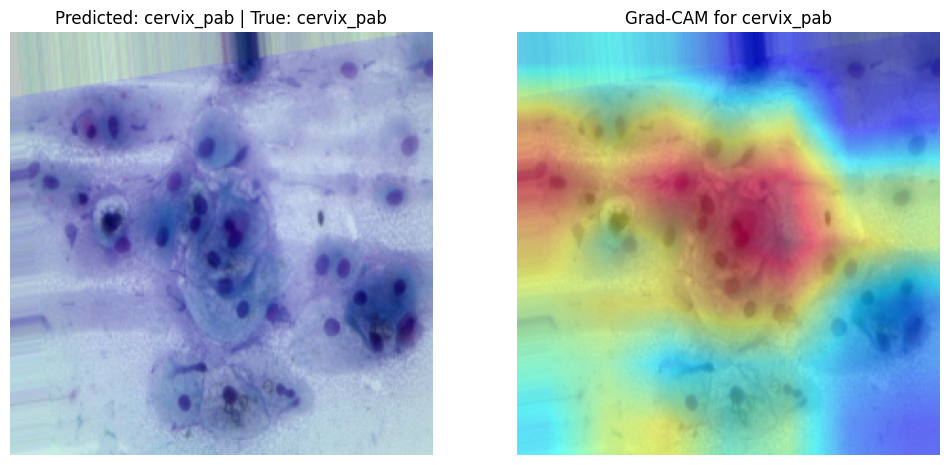

In [38]:
# Predict a random test image and Apply Grad-CAM
random_idx = random.randint(0, len(test_df) - 1)
img_path = test_df.iloc[random_idx]['filepath']
true_label = test_df.iloc[random_idx]['label']

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)
input_image = transform(pil_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_image)
    _, predicted_label = torch.max(output, 1)

targets = [ClassifierOutputTarget(predicted_label.item())]
# Resize ảnh gốc về đúng kích thước đầu vào của mô hình
image_resized = cv2.resize(np.array(pil_image), (224, 224))

# Tạo Grad-CAM heatmap
grayscale_cam = cam(input_tensor=input_image, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Overlay Grad-CAM lên ảnh resized
visualization = show_cam_on_image(image_resized.astype(np.float32) / 255, grayscale_cam, use_rgb=True)

# Hiển thị ảnh gốc và Grad-CAM heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_resized)  # Hiển thị ảnh đã resize
plt.title(f"Predicted: {cervix_categories[predicted_label.item()]} | True: {cervix_categories[true_label]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM for {cervix_categories[predicted_label.item()]}")
plt.axis('off')

plt.show()

## Chạy trên 4 models nữa (MobileNetV3, Vision Transfromer, EfficientNetV2 Small, DenseNet201), viết thuật toán tính TP TN TP FN => Precision, Focus Score
# 4 hình 2 class giống nhau 2 class khác 
# giả bộ 1 class 4 ảnh 2 giống class 2 ảnh class khác(random) 
# Chạy trên egientCAM  + GradCAM
# SHAP viết công thức extend LIME  
# Kiểm tra lại hàm Grad-CAM trước

